# Présence du monde académique dans les projets Open Source de Machine Learning : ces projets sont-ils faits par des chercheurs ?

Dans le cadre de nos recherches, nous nous interrogeons sur la participation du monde académique au sein des projets Open Source de Machine Learning.

Nos hypothèses sur la question sont les suivantes :
* Les contributeurs ne sont pas majoritairement académique.
* Les contributions viennent majoritairement de contributeurs académiques (en nombre de *commits* et en nombre de lignes).
* Les contributeurs académiques sont les contributeurs qui contribuent le plus individuellement (en nombre de *commits* et en nombre de lignes).
* La majorité des *commits* ajoutant des fonctionnalités proviennent de contributeurs académiques.

Les hypothèses de travail que nous posons concernent la bonne foi des contributeurs dans les informations de *commit*. En particulier :
* Le nom/prénom est celui de l'auteur.
* L'adresse mail appartient à l'auteur. Le domaine de l'adresse est celui d'une académie si il est contributeur académique ou d'une entreprise si le contributeur contribue dans le cadre de son travail en entreprise.

Pour étudier ces hypothèses et tenter de les réfuter, nous allons nous pencher sur les contributions de trois projets :
* [Scikit-Learn](http://scikit-learn.org/stable/) ([dépôt GitHub](https://github.com/scikit-learn/scikit-learn)).
* [Keras](https://keras.io/) ([dépôt GitHub](https://github.com/keras-team/keras)).
* [Theano](http://deeplearning.net/software/theano/) ([dépôt GitHub](https://github.com/Theano/Theano)).

Les données que nous allons exploiter dans ce document sont issues d'une extraction depuis leur dépôt Git respectif grâce à Repodriller. L'étude est reproductible avec le code disponible sur [notre dépôt GitHub](https://github.com/AntoineAube/reace-study).

In [22]:
# Let us import some awesome libraries!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scholarly
import progressbar
import os.path
import math

%matplotlib inline

# Just a bit of style. ;)
sns.set_palette(sns.color_palette('hls', 8))

In [7]:
# Let us load the datasets.
scikit_dataset = pd.read_csv('study-results/scikit-learn/exploration.csv')
keras_dataset = pd.read_csv('study-results/keras/exploration.csv')
theano_dataset = pd.read_csv('study-results/theano/exploration.csv')

# For example, let us take a look to the Scikit-Learn dataset.
scikit_dataset.sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES
19126,4ed425770a8974aa70c6f03814e3156c81262603,Yan Yi,seow.yanyi@gmail.com,1,1421606676000,2,2,0
10623,baf39adedad0e80af93b19e3d2451e426cb48a96,Lars Buitinck,larsmans@gmail.com,1,1349002403000,3,0,0
17635,65f4f953db64f9c3ac32b8742af04543d4465ae7,Hamzeh Alsalhi,ha258@cornell.edu,2,1406845658000,72,36,0
18678,acc25a47fd7233e8e16298b83fdf70b5137a0ba6,MechCoder,manojkumarsivaraj334@gmail.com,1,1419009657000,17,25,0
12290,7fb10b9be5cd8a5b905e180cc1cd759da43af19a,Andreas Mueller,amueller@ais.uni-bonn.de,1,1358083944000,18,6,0


## Quels sont les contributeurs académiques ?

Nous considérons que les contributeurs "académiques" sont les contributeurs dont la profession est de faire progresser la recherche (aussi bien des chercheurs en laboratoire de recherche que les chercheurs de l'industrie).

Pour répondre à cette question, nous avons pensé à deux approches pour classifier les contributeurs selon qu'ils sont académiques ou pas, et les avons mises en oeuvre :
* Utiliser le domaine de leur adresse mail : si le domaine de l'adresse appartient à une université ou bien spécifiquement à un chercheur, alors le contributeur associé est considéré académique.
* Chercher l'existence de l'auteur dans un moteur de recherche d'articles scientifiques : s'il contient au moins une publication du contributeur, alors il est considéré académique.

Nous nous attendons à une sélection plus dure avec la seconde approche (tout moteur de recherche ne recense pas tous les articles, ...) mais également plus rigoureuse (généralement, un contributeur non-académique ne publie pas d'article scientifique). La première approche est très peu précise (on ne peut rien déduire d'un domaine générique comme *gmail.com* donc il y aura inévitablement des faux négatifs).

In [8]:
def get_contributors(dataset):
    return dataset[['AUTHOR_NAME', 'AUTHOR_EMAIL']].drop_duplicates()

scikit_contributors = get_contributors(scikit_dataset)
keras_contributors = get_contributors(keras_dataset)
theano_contributors = get_contributors(theano_dataset)

all_contributors = scikit_contributors.merge(keras_contributors, how = 'outer').merge(theano_contributors, how = 'outer')

# Load the previously computed contributors and merge for the already known ones.
if os.path.isfile('study-results/contributors.csv'):
    computed_contributors = pd.read_csv('study-results/contributors.csv')
    
    all_contributors.merge(computed_contributors, how = 'outer')
else:
    all_contributors['HAS_ACADEMIC_EMAIL'] = np.NaN
    all_contributors['HAS_PUBLICATIONS'] = np.NaN
    
all_contributors.sample(5)

,AUTHOR_NAME,AUTHOR_EMAIL,HAS_ACADEMIC_EMAIL,HAS_PUBLICATIONS
2314,Samira Shabanian,s.shabanian@gmail.com,NaN,NaN
1721,Cristian Gratie,cgratie@gmail.com,NaN,NaN
2309,Moslem Kazemi,moslemk@users.noreply.github.com,NaN,NaN
2305,Sirisha Rambhatla,rambh002@umn.edu,NaN,NaN
1587,Mostafa Abdulhamid,dosht@users.noreply.github.com,NaN,NaN


### Approche exploitant les adresses mail

Nous étudions le domaine de l'adresse mail en procédant itérativement pour chaque dépôt étudié :
* Pour les contributions qui n'ont pas été marquées "académique" à l'étape précédente, nous extrayons le domaine.
* Nous listons ces domaines et les observons un à un (éventuellement, nous cherchons sur Internet). Nous l'ajoutons à notre liste blanche si elle correspond à un laboratoire de recherche ou à un chercheur en particulier.

Cette méthode est fastidieuse mais il n'y a pas vraiment le choix pour déterminer quelles adresses appartiennent à des chercheurs. Comme la détermination des domaines *académiques* est essentiellement manuelle, elle est sensible aux erreurs humaines...

In [9]:
def address_domain(address):
    split = address.split('@')
    
    if len(split) == 2:
        return split[1]
    else:
        return address
    
academic_domains = ['inria.fr', 'cnes.fr', 'normalesup.org', 'ensta.org', 'jnphilipp.org',
                    'vene.ro', 'cern.ch', 'uva.nl', 'cea.fr', 'heig-vd.ch', 'wxs.ca', 'smerity.com',
                    'nsup.org', 'esciencecenter.nl', 'centraliens.net', 'acm.org', 'fu-berlin.de', 
                    'fit.vutbr.cz', 'hec.ca', 'barvinograd.com', 'jakelee.net', 'maluuba.com',
                    'nicta.com.au', 'poli.ufrj.br', 'barkalov.ru', 'allenai.org', 'usherbrooke.ca',
                    'taehoonlee.com', 'bioinf.jku.at', 'nerdluecht.de', 'yosinski.com', 'tum.de',
                    'enlnt.com', 'kottalam.net', 'jan-schlueter.de', 'iupr.com', 'uoguelph.ca',
                    'marcodena.it', 'esimon.eu', 'stophr.be', 'jan-matthis.de', 'josephpcohen.com',
                    'cwi.nl']
academic_domains_ends = ['edu', 'ens-cachan.fr', 'intra.cea.fr', 'ntnu.no', 'umontreal.ca', 'mcgill.ca', 'epita.fr']
academic_domains_contents = ['.ca.', 'research', '.ac.', '.uu.', 'edu', 'student', 'uni', 'etu']

def is_academic_address(domain):
    for end in academic_domains_ends:
        if domain.endswith(end):
            return True
    
    for content in academic_domains_contents:
        if content in domain:
            return True
        
    return domain in academic_domains


all_contributors['HAS_ACADEMIC_EMAIL'] = all_contributors['AUTHOR_EMAIL'].apply(address_domain).apply(is_academic_address)

print('The approach with the mail addresses concluded that', len(all_contributors[all_contributors['HAS_ACADEMIC_EMAIL']]), 'contributors (out of', len(all_contributors), 'contributors) are academic ones.')

The approach with the mail addresses concluded that 355 contributors (out of 2520 contributors) are academic ones.


### Approche avec un moteur de recherche d'articles scientifiques

Nous cherchons le nom des contributeurs sur [Google Scholar](https://scholar.google.fr/). Il contient un très grand nombre de publications scientifiques sans limitation de domaine et dispose d'une API qui nous permet de l'interroger.

Les autres moteurs de recherche que nous avons expérimenté n'étaient pas à jour (*arXiv.org*, ...), soit spécifiques à d'autres domaines (notamment le domaine médical), soit ne proposent pas d'API (*ResearchGate*, ...).

Nous utilisons le module [scholarly](https://pypi.python.org/pypi/scholarly/0.2.3) qui pourvoie une API en Python pour consommer l'API de *Google Scholar*. Nous ne tenons compte que des contributeurs dont le nom est composé (au moins un prénom et un nom) et nous considérons qu'un contributeur est académique s'il existe un résultat à une requête d'auteur.

In [27]:
with progressbar.ProgressBar(max_value = len(all_contributors)) as bar:
    current = 0
    
    def is_academic_author(row):
        global current
        
        try:
            if math.isnan(row['HAS_PUBLICATIONS']):
                row['HAS_PUBLICATIONS'] = is_academic_author_by_name(row['AUTHOR_NAME'])
            
            return row
        finally:
            bar.update(current)
            current += 1
            
    def is_academic_author_by_name(author_name):
        if len(author_name.split()) < 2:
            # It is more likely a nickname, so we cannot conclude.
            return False
        else:
            try:
                author = next(scholarly.search_author(author_name.title()), None)

                return author != None
            except Exception:
                return np.NaN

    all_contributors = all_contributors.apply(is_academic_author, axis = 1)
    
print('The approach with Google Scholar concluded that', len(all_contributors[all_contributors['HAS_PUBLICATIONS']]), 'contributors (out of', len(all_contributors), 'contributors) are academic ones.')

100% (2520 of 2520) |#####################| Elapsed Time: 3:50:00 Time: 3:50:00


ValueError: cannot index with vector containing NA / NaN values

In [ ]:
all_contributors.to_csv('study-results/contributors.csv')

## Enrichissons les données

Pour pouvoir répondre aux questions suivantes, il va nous falloir enrichir les sets de données que nous avons chargé.

Nous allons ajouter les champs suivants :
* **PROJECT** : le nom du projet (utile pour fusionner les sets de données pour comparaison).
* **IS_ACADEMIC** : la contribution est-elle présumée venir d'un contributeur académique ?

In [4]:
# Add PROJECT.
scikit_dataset['PROJECT'] = 'Scikit-Learn'
keras_dataset['PROJECT'] = 'Keras'
theano_dataset['PROJECT'] = 'Theano'

In [5]:
# Add IS_ACADEMIC.
add_is_academic(scikit_dataset)
add_is_academic(keras_dataset)
add_is_academic(theano_dataset)

Nous créons un set de données collectant les données pour tous les projets étudiés.

In [6]:
all_datasets = pd.concat([scikit_dataset, keras_dataset, theano_dataset])

In [7]:
# For example, let us take a look to the Scikit-Learn dataset after the change.
all_datasets.sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT,IS_ACADEMIC
3209,b8cd122984facbefa06104da9a84e0b0b947c468,James Bergstra,bergstrj@iro.umontreal.ca,1,1266866531000,30,23,0,Theano,True
849,ec450f429ee40c8aa093c2a1add942018950fffa,forsythd,forsythd@email.chop.edu,1,1440002227000,1,1,0,Keras,True
18562,e4f4f6df1bfe49bc3bb1ce81d4e95d35343a0a9d,Clemens Brunner,clemens.brunner@gmail.com,1,1414350984000,6,1,0,Scikit-Learn,False
18051,8c512d7f36495a031cf1f09bdb964c649b4e5e01,Li Yao,li.yao@umontreal.ca,1,1430760398000,4,12,0,Theano,True
3973,b24f44480a32e9911a0a8f7a845bc82c877be653,Fariz Rahman,farizrahman4u@gmail.com,1,1505508510000,1,0,0,Keras,False


## Les contributeurs académiques sont-ils majoritaires ?

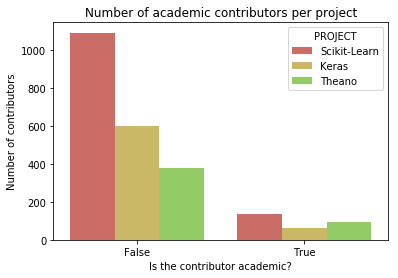

In [8]:
sns.countplot('IS_ACADEMIC', hue = 'PROJECT', data = all_datasets.drop_duplicates(['PROJECT', 'AUTHOR_NAME']))

plt.title('Number of academic contributors per project')
plt.xlabel('Is the contributor academic?')
plt.ylabel('Number of contributors');

In [9]:
def academic_contributors(project_name, project_dataset):
    without_duplicates = project_dataset.drop_duplicates(['AUTHOR_NAME'])
    percents = 100 * without_duplicates.groupby(['IS_ACADEMIC'])['COMMIT_HASH'].count() / len(without_duplicates)
    
    academic_contributors = '%.2f' % percents[True]
    non_academic_contributors = '%.2f' % percents[False]
    
    print('Participation (in # of contributors) for project \'' + project_name + '\', there has been:')
    print(' -     Academic contributors:', academic_contributors + '%')
    print(' - Non academic contributors:', non_academic_contributors + '%')

academic_contributors('Scikit', scikit_dataset)
print()
academic_contributors('Keras', keras_dataset)
print()
academic_contributors('Theano', theano_dataset)

Participation (in # of contributors) for project 'Scikit', there has been:
 -     Academic contributors: 11.23%
 - Non academic contributors: 88.77%

Participation (in # of contributors) for project 'Keras', there has been:
 -     Academic contributors: 9.68%
 - Non academic contributors: 90.32%

Participation (in # of contributors) for project 'Theano', there has been:
 -     Academic contributors: 20.17%
 - Non academic contributors: 79.83%


## Les contributions viennent-elles majoritairement de contributeurs académiques ?

### En nombre de *commits*

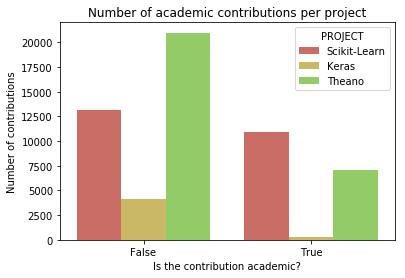

In [10]:
sns.countplot('IS_ACADEMIC', hue = 'PROJECT', data = all_datasets)

plt.title('Number of academic contributions per project')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of contributions');

In [11]:
def academic_commits_contributions(project_name, project_dataset):
    percents = 100 * project_dataset.groupby(['IS_ACADEMIC']).size() / len(project_dataset)
    
    academic_contribution = '%.2f' % percents[True]
    non_academic_contribution = '%.2f' % percents[False]
    
    print('Participation (in # of commits) for project \'' + project_name + '\', there has been:')
    print(' -     Academic contributors:', academic_contribution + '%')
    print(' - Non academic contributors:', non_academic_contribution + '%')

academic_commits_contributions('Scikit', scikit_dataset)
print()
academic_commits_contributions('Keras', keras_dataset)
print()
academic_commits_contributions('Theano', theano_dataset)

Participation (in # of commits) for project 'Scikit', there has been:
 -     Academic contributors: 45.45%
 - Non academic contributors: 54.55%

Participation (in # of commits) for project 'Keras', there has been:
 -     Academic contributors: 5.45%
 - Non academic contributors: 94.55%

Participation (in # of commits) for project 'Theano', there has been:
 -     Academic contributors: 25.11%
 - Non academic contributors: 74.89%


### En nombre de lignes ajoutées/retirées

In [12]:
def academic_lines_contributions(project_name, project_dataset, field):
    percents = 100 * project_dataset.groupby(['IS_ACADEMIC'])[field].sum() / project_dataset[field].sum()
    
    academic_contribution = '%.2f' % percents[True]
    non_academic_contribution = '%.2f' % percents[False]
    
    print('Participation (in # of ' + field + ') for project \'' + project_name + '\', there has been:')
    print(' -     Academic contributors:', academic_contribution + '%')
    print(' - Non academic contributors:', non_academic_contribution + '%')

def academic_added_lines_contributions(project_name, project_dataset):
    academic_lines_contributions(project_name, project_dataset, 'ADDED_LINES')
    
def academic_deleted_lines_contributions(project_name, project_dataset):
    academic_lines_contributions(project_name, project_dataset, 'DELETED_LINES')
    
academic_added_lines_contributions('Scikit', scikit_dataset)
print()
academic_added_lines_contributions('Keras', keras_dataset)
print()
academic_added_lines_contributions('Theano', theano_dataset)

print()
print()

academic_deleted_lines_contributions('Scikit', scikit_dataset)
print()
academic_deleted_lines_contributions('Keras', keras_dataset)
print()
academic_deleted_lines_contributions('Theano', theano_dataset)

Participation (in # of ADDED_LINES) for project 'Scikit', there has been:
 -     Academic contributors: 28.81%
 - Non academic contributors: 71.19%

Participation (in # of ADDED_LINES) for project 'Keras', there has been:
 -     Academic contributors: 3.62%
 - Non academic contributors: 96.38%

Participation (in # of ADDED_LINES) for project 'Theano', there has been:
 -     Academic contributors: 29.77%
 - Non academic contributors: 70.23%


Participation (in # of DELETED_LINES) for project 'Scikit', there has been:
 -     Academic contributors: 32.07%
 - Non academic contributors: 67.93%

Participation (in # of DELETED_LINES) for project 'Keras', there has been:
 -     Academic contributors: 3.93%
 - Non academic contributors: 96.07%

Participation (in # of DELETED_LINES) for project 'Theano', there has been:
 -     Academic contributors: 30.28%
 - Non academic contributors: 69.72%


## Les contributeurs académiques sont-ils les contributeurs qui contribuent le plus  individuellement ?

### En nombre de *commits* par contributeur

In [13]:
# TODO

### En nombre de fichiers modifiés par *commit*

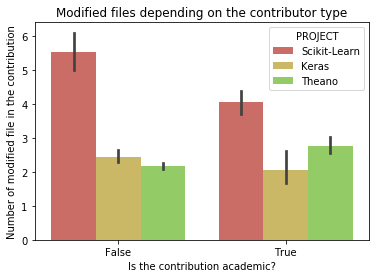

In [14]:
sns.barplot(x = 'IS_ACADEMIC', y = 'MODIFICATIONS_COUNT', hue = 'PROJECT', data = all_datasets)

plt.title('Modified files depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of modified file in the contribution');

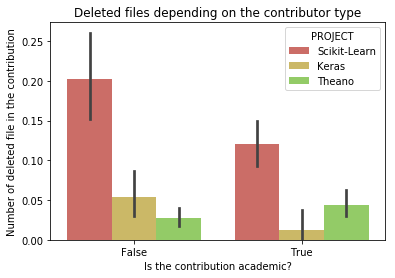

In [15]:
sns.barplot(x = 'IS_ACADEMIC', y = 'DELETED_FILES', hue = 'PROJECT', data = all_datasets)

plt.title('Deleted files depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of deleted file in the contribution');

### En nombre de lignes ajoutées/retirées par *commit*

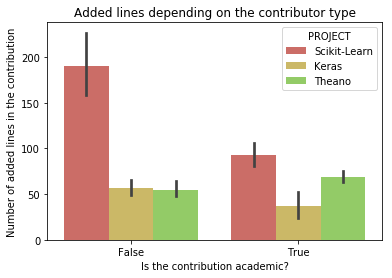

In [16]:
sns.barplot(x = 'IS_ACADEMIC', y = 'ADDED_LINES', hue = 'PROJECT', data = all_datasets)

plt.title('Added lines depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of added lines in the contribution');

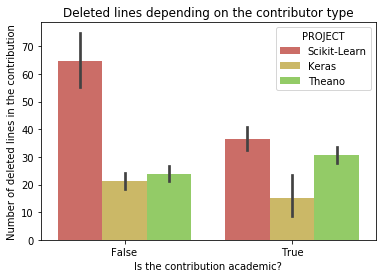

In [17]:
sns.barplot(x = 'IS_ACADEMIC', y = 'DELETED_LINES', hue = 'PROJECT', data = all_datasets)

plt.title('Deleted lines depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of deleted lines in the contribution');